<font color='#51624F' size="10">Maruti Stock Sentiment Analysis 
    
    
<b> Headline Data : </b> Headlines from MoneyControl News website
<b> Stock Price Data </b>: Yahoo finance stock price data for years 2020-2021
    

In [ ]:
! pip install beautifulsoup4                   

In [ ]:
! pip install requests                       

In [ ]:
! pip install sklearn                 

In [ ]:
! pip install pandas                

In [ ]:
! pip install matplotlib              

In [ ]:
import requests
from bs4 import BeautifulSoup

<font style  color=#BBB6A5 size="6"> <b>Scraping News Headlines from MoneyControl

In [ ]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.81 Safari/537.36'}




maruti = []         # for storing a list of dictionaries MarutiHeadline with keys 'headline' and 'date'

def getHeadline(year,page):
    # URL of Money control page with 'page' and 'year' input from function parameters 
    
    url = f"https://www.moneycontrol.com/stocks/company_info/stock_news.php?sc_id=MU01&scat=&pageno={page}&next=0&durationType=Y&Year={year}&duration=1&news_type="

    r = requests.get(url, headers=headers)                           #requesting the URL 

    soup = BeautifulSoup(r.text, 'html.parser')                       #creating BeautifulSoup object

    #accessing all the Headline packets (containing headline,subheadline and date) from the given webpage 
    headPack = soup.find_all('div', {'class': 'MT15 PT10 PB10'})

    #iterating through each headline packet to extract date and healdline text
    for item in headPack:
        
        headline = item.text.replace(item.find('p', {'class': 'PT3 a_10dgry'}).text,' ')  #extracting full headline(main+sub-headline) without date
        headline = headline.strip()          # removing \n
        date = item.find('p', {'class': 'PT3 a_10dgry'}).text        # extracting date column
        #creating a dictionary with keys 'headline' and 'date'
        MarutiHeadline = {
        'headline':headline,
        'date': date[date.index('|')+2:date.index('\xa0|\xa0')]   }        # trimming out excess content to get  only the date

        #appending the dictionary to a list maruti
        maruti.append(MarutiHeadline)
    
    return

#iterating through all 7 pages of headlines for the year 2021
for i in range(1,7):
    getHeadline('2021',i)
   
 #iterating through all 12 pages of headlines for the year 2020
for i in range(1,12):
    getHeadline('2020',i)

#Comnverting Date to Number format  (Ex 21 Sep 2021 to 21-09-2021)
for obje in maruti:
    
    date = obje.get('date')
    
    month = date[3:6]
    monthofyear = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
    i = 1
    for m in monthofyear:
        if month == m and i<10:
            obje['date']=date[0:2]+'-0'+str(i)+'-'+date[7:]
            
        if month == m and i>10:
            obje['date']=date[0:2]+'-'+str(i)+'-'+date[7:]
        
        i+=1


        
        
print(len(maruti))
    
      

328


<font color= #AEBEA1 size="6"> <b>NLP Model 

In [ ]:
import pandas as pd

In [ ]:
df=pd.read_csv('MARUTI.NS.csv', encoding = "ISO-8859-1")

The Stock data downloaded from Yahoo finance and a value column is added with 

<b>Value = 1 </b>, when stock price increases from previous day

<b>Value = 0 </b>, when stock price decreases from previous day

The NLP model will be trained on this output data set , and this model, when trained accurately, will output 1, when headline text indicates stock price increase and 0 if headline text indicates stock price decrease.

In [ ]:
df.head()         # I have set the Value to 1 if the stock increased from previous day, and 0 if it had decreased from previous day

,Date,Open,Value
0,17-10-2019,6977.000000,1
1,18-10-2019,7081.299805,1
2,22-10-2019,7333.000000,1
3,23-10-2019,7201.049805,0
4,24-10-2019,7460.000000,1


In [ ]:
#converting date to our required date format (%d-%m-%Y  String) and storing it in a list of strongs 'dateList' 

dateFormat = pd.to_datetime(df['Date'], dayfirst=True)    #converting the string column to pandas date format 

dateList = dateFormat.dt.strftime('%d-%m-%Y')   #converting pandas date format back into required string format


In [ ]:

#newDictionary of date vs words
newDict={}
for obj in maruti:
    
    newDict[obj['date'] ] = ''

    
#appending all the headlines belonging to a particular date into a single healdine and storing it in a dictionary with keys = 
for obj in maruti:
    
     newDict[obj['date'] ] = newDict[obj['date'] ]+' '+ (obj['headline']) 
        
        
newDictTuple = [(k, v) for k, v in newDict.items()]        # converting the Dictionary newDict into a list of tuples for manipulation
headlinelist = []        


stockpricelist=[]
output = []


''' Headline articles are not present for all the days of the week, hence ,
I have only taken considered stick prices on the days on which headline articles are written'''


for l in newDictTuple:
    
    #removing special characters
    string = l[1]
    new_string = ''.join(char.lower() for char in string if char.isalnum() or char.isspace() )
    headlinelist.append(new_string.replace("\n"," "))
    
    i=0
    for date in dateList:
        if(l[0]==date):
            ind = i
            break
        i+=1
        
    output.append(df['Value '][ind])
    stockpricelist.append(df['Open'][ind])


In [ ]:

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# implement BAG OF WORDS
trainList = headlinelist[0:200]
testList = headlinelist[200:235]

countvector=CountVectorizer(ngram_range=(2,2))
traindataset=countvector.fit_transform(trainList)

In [ ]:

# implementing RandomForest Classifier
randomclassifier=RandomForestClassifier(n_estimators=200,criterion='entropy')
randomclassifier.fit(traindataset,output[0:200])

RandomForestClassifier(criterion='entropy', n_estimators=200)

In [ ]:

test_dataset = countvector.transform(testList)
predictions = randomclassifier.predict(test_dataset)

In [ ]:
## Import library to check accuracy
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [ ]:
matrix=confusion_matrix(output[200:235],predictions)
print(matrix)
score=accuracy_score(output[200:235],predictions)
print(score)
report=classification_report(output[200:235],predictions)
print(report)

[[19  3]
 [13  0]]
0.5428571428571428
              precision    recall  f1-score   support

           0       0.59      0.86      0.70        22
           1       0.00      0.00      0.00        13

    accuracy                           0.54        35
   macro avg       0.30      0.43      0.35        35
weighted avg       0.37      0.54      0.44        35



<font color=#A2B4AC size=6> <b>Plotting


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# prediction for entire dataset of headlines
test_transform = headlinelist
test_dataset = countvector.transform(test_transform)
predictionTotal = randomclassifier.predict(test_dataset)

In [ ]:
newdateList=[]
for l in newDictTuple:
    newdateList.append(l[0])

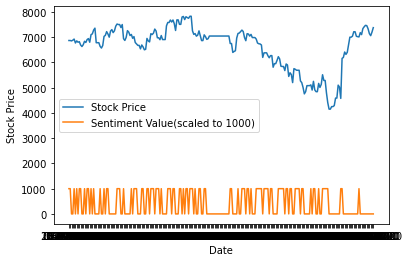

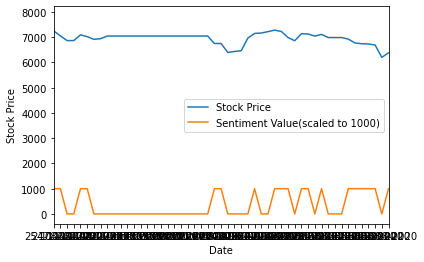

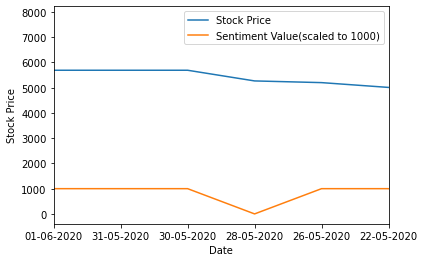

In [25]:
normalizedStockprice = [ i/1000 for i in stockpricelist]


xVals = range(len(normalizedStockprice))
plt.figure(0)
plt.plot(xVals, normalizedStockprice)
plt.plot(xVals, predictionTotal)
plt.xticks(xVals, newdateList)
plt.ylabel('Stock Price')
plt.xlabel('Date')
plt.legend(['Stock Price','Sentiment Value(scaled to 1000)'])
plt.yticks([i for i in range(9)],[1000*i for i in range(9)] )

plt.figure(1) 
plt.plot(xVals, normalizedStockprice)
plt.plot(xVals, predictionTotal)
plt.xticks(xVals, newdateList)
plt.yticks([i for i in range(9)],[1000*i for i in range(9)] )
plt.ylabel('Stock Price')
plt.xlabel('Date')
plt.xlabel('Date')
plt.legend(['Stock Price','Sentiment Value(scaled to 1000)'])
plt.xlim([100, 150])  
plt.show()

plt.figure(2)
plt.plot(xVals, normalizedStockprice)
plt.plot(xVals, predictionTotal)
plt.xticks(xVals, newdateList)
plt.yticks([i for i in range(9)],[1000*i for i in range(9)] )
plt.xlim([175, 180])  
plt.ylabel('Stock Price')
plt.xlabel('Date')
plt.xlabel('Date')
plt.legend(['Stock Price','Sentiment Value(scaled to 1000)'])
plt.show()

